In [1]:
import pymysql as mdb
import pandas as pd
from pandas import Series,DataFrame
con = mdb.connect('localhost', 'root', '', 'r1') #host, user, password, #database

In [2]:
with con:
   cur = con.cursor()
   cur.execute("DROP TABLE IF EXISTS users_query")
   cur.execute("""
   CREATE TABLE users_query(
      date DATE,
      userid BIGINT,
      siteid CHAR(20),
      timestamp BIGINT,
      visit INT);
   """)
   cur.execute("""
   LOAD DATA INFILE 'insight_site_staging_3M.txt' 
   INTO TABLE users_query 
   FIELDS TERMINATED BY '\t'
   LINES TERMINATED BY '\n';
   """)

In [3]:
with con:
   cur = con.cursor()
   users = pd.read_sql_query(
        """SELECT userid,siteid
        FROM users_query WHERE siteid <> 'Null'
        ;""",
        con
        )

In [4]:
with con:
   cur = con.cursor()
   cur.execute("DROP TABLE IF EXISTS conv_query")
   cur.execute("""
   CREATE TABLE conv_query(
      date DATE,
      userid BIGINT,
      siteid CHAR(20),
      timestamp BIGINT,
      visit INT);
   """)
   cur.execute("""
   LOAD DATA INFILE 'insight_converter_site_history.txt' 
   INTO TABLE conv_query 
   FIELDS TERMINATED BY '\t'
   LINES TERMINATED BY '\n';
   """)

In [5]:
with con:
   cur = con.cursor()
   conv = pd.read_sql_query(
        """SELECT userid,siteid
        FROM conv_query WHERE siteid <> 'Null'
        ;""",
        con
        )

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
sns.set(style="whitegrid")

In [7]:
group_conv_query=conv.groupby(['siteid'])
group_users_query=users.groupby(['siteid'])

In [8]:
group_conv_query_sorted=group_conv_query.count().sort(['userid'],ascending=[0]).userid
group_users_query_sorted=group_users_query.count().sort(['userid'],ascending=[0]).userid

In [17]:
group_conv_query_sorted.head()

siteid
5             130079
1099962644    120150
388           119193
81309          82354
81726          70550
Name: userid, dtype: int64

In [9]:
df_conv_site = DataFrame({'number_users': list(group_conv_query_sorted.values)},index = list(group_conv_query_sorted.index))
df_users_site = DataFrame({'number_users': list(group_users_query_sorted.values)},index = list(group_users_query_sorted.index))

In [18]:
df_conv_site.head()

,number_users
5,130079
1099962644,120150
388,119193
81309,82354
81726,70550


In [33]:
df_conv_site['binned'] = df_conv_site['number_users'].map(lambda x: int(x/100)*100)

In [34]:
df_conv_site

,number_users,binned
5,130079,130000
1099962644,120150,120100
388,119193,119100
81309,82354,82300
81726,70550,70500
1334653,43482,43400
83981,43090,43000
585119,39888,39800
521,31933,31900
84734,28686,28600


In [44]:
bins_nconv = df_conv_site.drop(['number_users'],axis=1).apply(pd.value_counts).fillna(0)

In [52]:
bins_nconv.tail()

,binned,bin_nusers
13200,1,1885
16800,1,2400
8700,1,1242
22700,1,3242
23700,1,3385


In [51]:
#bins_nconv['sitesperbin']=bins_nconv['number_users']
bins_nconv['bin_nusers']=(bins_nconv.index//7.)

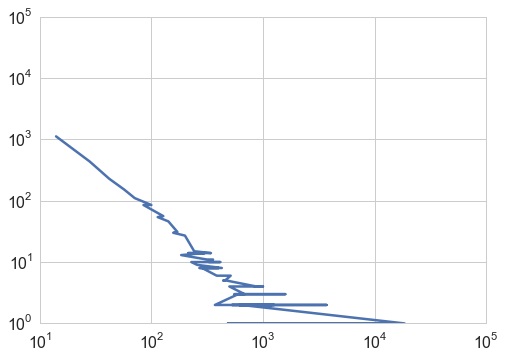

In [54]:
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots()
ax.loglog(bins_nconv.bin_nusers,bins_nconv.binned, label="converters")

In [11]:
bins_nconv_sorted=bins_nconv.drop(['number_users'],axis=1).sort(['sitesperbin'])
#bins_nconv_sorted.head(3)

In [14]:
bins_nusers = df_users_site.apply(pd.value_counts).fillna(0)
bins_nusers['sitesperbin']=bins_nusers['number_users']
bins_nusers['bin_nusers']=bins_nusers.index*(470.015970/3.)
bins_nusers_sorted=bins_nusers.drop(['number_users'],axis=1).sort(['sitesperbin'])
#bins_nusers_sorted.head(30)

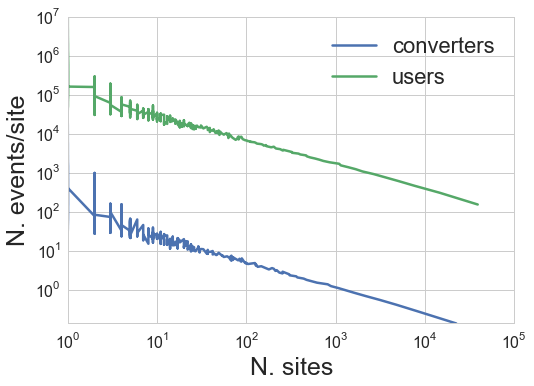

In [15]:
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots()
ax.loglog(bins_nconv_sorted.sitesperbin,bins_nconv_sorted.bin_nusers, label="converters")
ax.loglog(bins_nusers_sorted.sitesperbin,bins_nusers_sorted.bin_nusers, label="users")
#ax.set_yscale("log")
ax.legend(["converters", "users"], fontsize=22);
ax.set_ylim([0, 10000000])
ax.set_xlim([0, 100000])
ax.set_xlabel(r'N. sites', fontsize=25)
ax.set_ylabel(r'N. events/site', fontsize=25)
#plt.scatter(bins_nusers_sorted_sample.bin_nusers,bins_nusers_sorted_sample.integral)
#plt.gca().set_xscale("log")
#plt.show()